# Learning

In this notebook we try to learn a policy to navigate in a corridor with one obstacle. We fix the model (an MLP with two layers with 128 neurons) and applies three learning algorithms,
providing during training more or less the same number of simulation steps:

- Behavioral cloning (IL)
- DAgger (IL)
- SAC (RL)


Note, that we could skip training by loading the policies saved in this directory.

In [1]:
import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_formats = ['svg']

We start by recording the current time, which we will add to the logging directories 

In [2]:
from datetime import datetime as dt

stamp = dt.now().strftime("%Y%m%d_%H%M%S")

and by initializing the same environment as in the [previous notebook](Scenario.ipynb), but with a flat observation space because it is the only one supported all three learning algorithms we are going to apply.

In [3]:
import gymnasium as gym
from navground import sim
from navground.learning import ControlActionConfig, DefaultObservationConfig
from navground.learning.rewards import SocialReward
import navground.learning.scenarios

duration = 40.0
time_step = 0.1

action_config = ControlActionConfig(max_acceleration=1.0, max_angular_acceleration=10.0, 
                                    use_acceleration_action=True)

observation_config = DefaultObservationConfig(include_target_direction=True, include_velocity=True, 
                                              include_angular_speed=True, flat=True)

reward = SocialReward(safety_margin=0.04)

with open('sensor.yaml') as f:
    sensor = sim.load_state_estimation(f.read())

with open('scenario.yaml') as f:
    scenario = sim.load_scenario(f.read())
    
env = gym.make('navground', 
    scenario=scenario,
    sensor=sensor,
    action=action_config,
    observation=observation_config,
    time_step=time_step,
    max_duration=duration,
    reward=reward)

together with an evaluation environment:

In [4]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env

# uses random seed
test_env = make_vec_env('navground', n_envs=5, env_kwargs=env.spec.kwargs)

We also define helper functions to plot and display runs when the agent following different policies

In [5]:
from matplotlib import pyplot as plt
from navground.learning import GroupConfig
from navground.learning.evaluation import make_experiment_with_env
from navground.sim.pyplot_helpers import plot_runs
import numpy as np

def plot_test_runs(policy, color='blue', figsize=(12, 8), cols=4, 
                   rows=5, step=30, seed=0):
    fig, _ = plt.subplots(rows, cols, figsize=figsize)
    exp = make_experiment_with_env(env=env.unwrapped, 
                                   groups=[GroupConfig(policy=policy)])
    exp.number_of_runs = rows * cols
    exp.record_config.pose = True
    exp.run_index = seed
    exp.run()
    plot_runs(runs=exp.runs.values(), columns=cols, with_agent=True, 
              color=lambda a: color, step=step, 
              world_kwargs={'in_box': True}, 
              agent_kwargs={'dot_radius': 0, 'with_safety_margin': True}, 
              fig=fig)

All policies will share the same network architecture with two layers of 128 neurons each

In [6]:
policy_kwargs = dict(net_arch=[128, 128])

## Imitation Learning with Behavior Cloning

To load a pre-trained policy, uncomment and execute the next cell

In [7]:
from navground.learning.il import BC

bc = BC.load("BC/model.zip")

In [32]:
from navground.learning.il import BC, setup_tqdm
from imitation.util import logger

setup_tqdm()

bc = BC(env, policy_kwargs=dict(net_arch=[128, 128]), 
        bc_kwargs={'l2_weight': 0, 'ent_weight': 1e-2, 'batch_size': 32})
bc.logger = logger.configure(f"logs/BC/{stamp}", ['tensorboard', 'csv'])

In [33]:
import time

start = time.time()
bc.collect_runs(750)
print(f'Collecting runs took {time.time() - start: .0f} seconds')

start = time.time()
bc.learn(
    log_rollouts_venv=test_env, 
    log_rollouts_n_episodes=50,
    log_interval=500,
    n_epochs=4,
    progress_bar=True
)
print(f'Training took {time.time() - start: .0f} seconds')
bc.save("BC/model")

0batch [00:00, ?batch/s]

Training took  64 seconds


Even with a quite large number of steps (about 100K per epoch), it fails to learn a decent policy

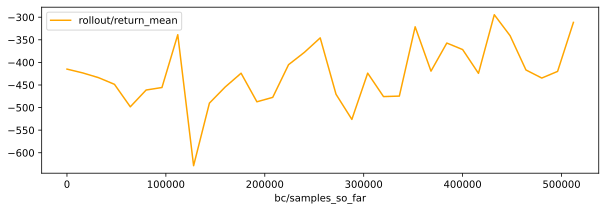

In [34]:
import pandas as pd

df = pd.read_csv(f'{bc.logger.get_dir()}/progress.csv')
df.plot(y='rollout/return_mean', x='bc/samples_so_far', figsize=(10, 3), color='orange');

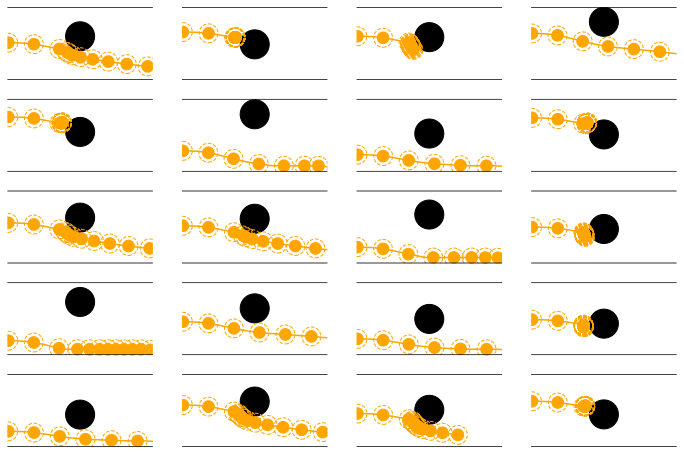

In [35]:
plot_test_runs(policy=bc.policy, color='orange', seed=10000);

In [36]:
bc_rewards, steps = evaluate_policy(bc.policy, test_env, 1000, return_episode_rewards=True)

print(f"BC Rewards: min={np.min(bc_rewards):.2f}, mean={np.mean(bc_rewards):.2f}, "
      f"median={np.median(bc_rewards):.2f}, max={np.max(bc_rewards):.2f}")

BC Rewards: min=-673.52, mean=-352.38, median=-386.20, max=-1.86


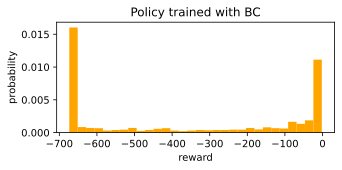

In [37]:
plt.figure(figsize=(5, 2))
plt.hist(bc_rewards, bins=30, density=True, color="orange");
plt.xlabel('reward')
plt.ylabel('probability')
plt.title("Policy trained with BC");

## Imitation learning with DAgger

To load a pre-trained policy, uncomment and execute the next cell

In [14]:
from navground.learning.il import DAgger

dagger = DAgger.load("DAgger/model.zip")

In [15]:
from navground.learning.il import DAgger

dagger = DAgger(env, policy_kwargs=dict(net_arch=[128, 128]), 
                bc_kwargs={'l2_weight': 0, 'ent_weight': 1e-2, 'batch_size': 128})
dagger.logger = logger.configure(f"logs/DAgger/{stamp}", ['tensorboard', 'csv'])

In [16]:
import time

start = time.time()
dagger.learn(
    total_timesteps=100_000,
    rollout_round_min_episodes=25,
    bc_train_kwargs={
        'log_rollouts_venv': test_env, 
        'log_rollouts_n_episodes': 50,
        'log_interval': 500,
        'n_epochs': 1,
        'progress_bar': False,
    },
    progress_bar=True
)
print(f'Training took {time.time() - start: .0f} seconds')
dagger.save("DAgger/model.zip")

Output()

Training took  77 seconds


About 60000 steps are enough to learn a decent policy

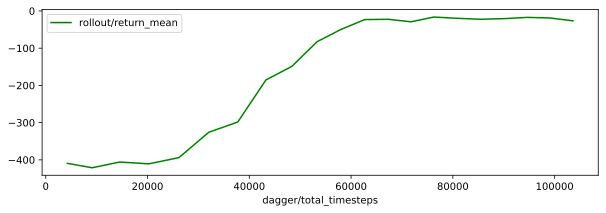

In [17]:
import pandas as pd

df = pd.read_csv(f'{dagger.logger.get_dir()}/progress.csv')
df = df[df['dagger/total_timesteps'].notna()]
df.plot(y='rollout/return_mean', x='dagger/total_timesteps', figsize=(10, 3), color='green');

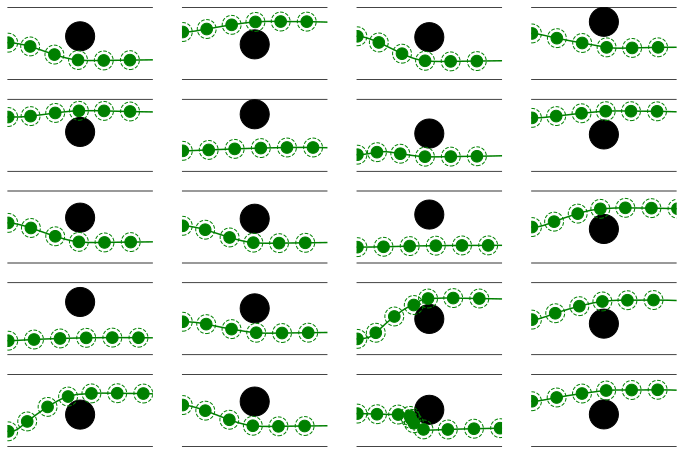

In [18]:
plot_test_runs(policy=dagger.policy, seed=10000, color='green')

In [19]:
dagger_rewards, steps = evaluate_policy(dagger.policy, test_env, 1000, return_episode_rewards=True)

print(f"DAgger Rewards: min={np.min(dagger_rewards):.2f}, mean={np.mean(dagger_rewards):.2f}, "
      f"median={np.median(dagger_rewards):.2f}, max={np.max(dagger_rewards):.2f}")

DAgger Rewards: min=-357.68, mean=-15.64, median=-8.91, max=-0.23


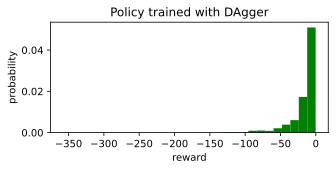

In [20]:
plt.figure(figsize=(5, 2))
plt.hist(dagger_rewards, bins=30, density=True, color="green");
plt.xlabel('reward')
plt.ylabel('probability');
plt.title("Policy trained with DAgger");

## Reinforcement learning with SAC

To load a pre-trained policy, uncomment and execute the next cell

In [21]:
from stable_baselines3 import SAC

sac = SAC.load("SAC/model.zip")

In [22]:
from stable_baselines3 import SAC
from stable_baselines3.common.logger import configure

sac = SAC("MlpPolicy", env, policy_kwargs=policy_kwargs)
sac.set_logger(configure(f"logs/SAC/{stamp}", ["csv", "tensorboard"]))

In [23]:
import time

start = time.time()
sac.learn(total_timesteps=100_000, progress_bar=True, tb_log_name="SAC");
print(f'Training took {time.time() - start: .0f} seconds')
sac.save("SAC/model.zip")

Output()

Training took  371 seconds


It learns at good performing policy in about 50000 steps. It takes about 5x longer compared to Dagger but the policy is also better, especialy the worst case.

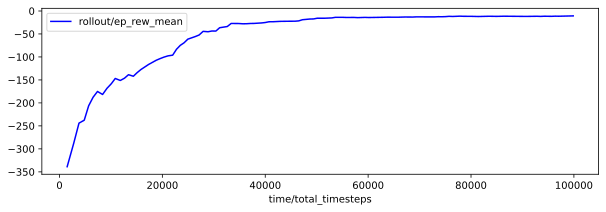

In [24]:
import pandas as pd

df = pd.read_csv(f'{sac.logger.get_dir()}/progress.csv')
df.plot(y='rollout/ep_rew_mean', x='time/total_timesteps', figsize=(10, 3), color='blue');

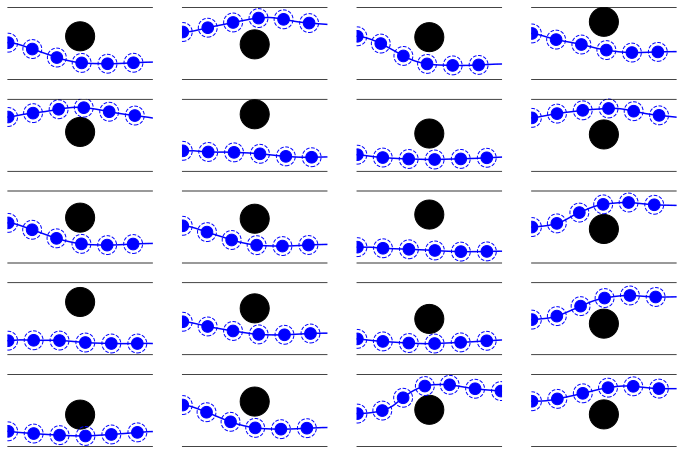

In [25]:
plot_test_runs(policy=sac.policy, seed=10_000, color='blue') 

In [26]:
sac_rewards, steps = evaluate_policy(sac.policy, test_env, 1000, return_episode_rewards=True)

print(f"SAC Rewards: min={np.min(sac_rewards):.2f}, mean={np.mean(sac_rewards):.2f}, "
      f"median={np.median(sac_rewards):.2f}, max={np.max(sac_rewards):.2f}")

SAC Rewards: min=-349.33, mean=-7.87, median=-5.29, max=-0.88


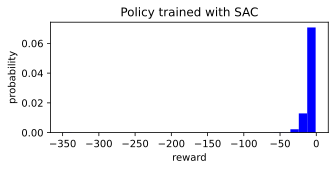

In [27]:
plt.figure(figsize=(5, 2))
plt.hist(sac_rewards, bins=30, density=True, color='blue');
plt.xlabel('reward')
plt.ylabel('probability');
plt.title("Policy trained with SAC");

## Comparision with HL 

Let's compare the policies with the expert (algorithm) that we have learned to imitate (HL).

In [28]:
from navground.learning.evaluation import evaluate_with_experiment_and_env

hl_rewards, _ = evaluate_with_experiment_and_env(env, n_eval_episodes=1000, return_episode_rewards=True)

print(f"HL Rewards: min={np.min(hl_rewards):.2f}, mean={np.mean(hl_rewards):.2f}, "
      f"median={np.median(hl_rewards):.2f}, max={np.max(hl_rewards):.2f}")

HL Rewards: min=-71.02, mean=-5.36, median=-3.95, max=0.00


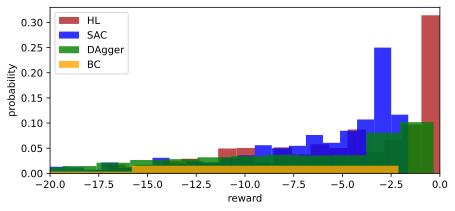

In [38]:
plt.figure(figsize=(7, 3))

plt.hist(hl_rewards, color='firebrick', density=True, label="HL", alpha=0.8, 
         bins=np.linspace(np.quantile(hl_rewards, 0.02), np.quantile(hl_rewards, 0.98), 20))
plt.hist(sac_rewards, color='blue', density=True, label="SAC", alpha=0.8, 
         bins=np.linspace(np.quantile(sac_rewards, 0.02), np.quantile(sac_rewards, 0.98), 30))

plt.hist(dagger_rewards, color='green', density=True, label="DAgger", alpha=0.8, 
         bins=np.linspace(np.quantile(dagger_rewards, 0.02), np.quantile(dagger_rewards, 0.98), 50))
plt.hist(bc_rewards, color='orange', density=True, label="BC", alpha=0.8,
         bins=np.linspace(np.quantile(bc_rewards, 0.02), np.quantile(bc_rewards, 0.98), 50))

plt.xlabel('reward')
plt.ylabel('probability');
plt.xlim(-20, 0)
plt.legend();

In [39]:
def plot_comparison_test_runs(policies, figsize=(12, 8), cols=4, rows=5, step=30, seed=0):
    fig, _ = plt.subplots(rows, cols, figsize=figsize)
    for i, (policy, color, label) in enumerate(policies):
        exp = make_experiment_with_env(env=env.unwrapped, groups=[GroupConfig(policy=policy)])
        exp.number_of_runs = rows * cols
        exp.record_config.pose = True
        exp.run_index = seed
        exp.run()
        plot_runs(runs=exp.runs.values(), columns=cols, with_agent=False, color=lambda a: color, step=step, 
              world_kwargs={'in_box': True}, fig=fig, with_world=i==0, label=label)

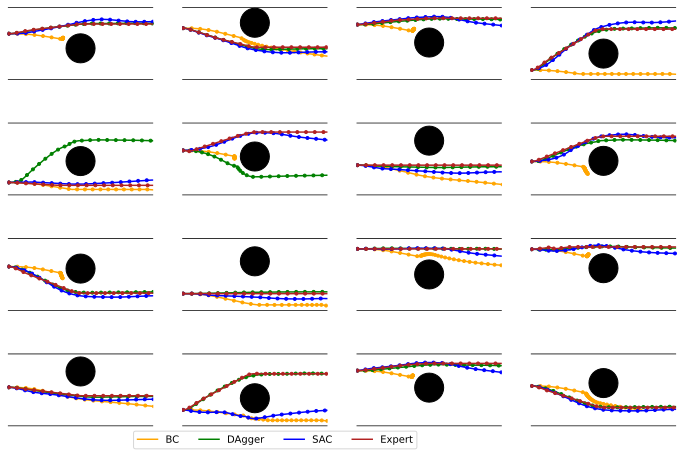

In [40]:
plot_comparison_test_runs(policies=(
    (bc.policy, 'orange', 'BC'), 
    (dagger.policy, 'green', 'DAgger'), 
    (sac.policy, 'blue', 'SAC'),
    (None, 'firebrick', 'Expert')), seed=123, step=10, cols=4, rows=4)
plt.legend(bbox_to_anchor=(-.75, 0), ncols=4);